In [1]:
using Dates
using Plots
using Statistics
using LinearAlgebra
using Distributed
using BSON: @save, @load

if nworkers() == 1
    BLAS.set_num_threads(1)
    addprocs(4)
end

@everywhere begin
    include("../src/distances.jl")
    include("../src/readLJ.jl")
    include("../src/ML-IMC.jl");
end

## 1. The first iteration

## 1.1. Input data 

In [2]:
bins, rdfref, histref = readRDF("../mcLJ/rdf-mean-p40.dat")
histref ./= 500;


Reading reference data from ../mcLJ/rdf-mean-p40.dat...


In [3]:
xyz = readXYZ("../mcLJ/mctraj-p001.xyz")
conf = xyz[end]

parameters = readinput("LJML-init.in")


Reading ../mcLJ/mctraj-p001.xyz with 6012 lines...
Found 6 frames with 1000 atoms each...
Success! Closing the file...


inputParms([36.405, 36.405, 36.405], 1.266025230073036, 0.75, 2000000, 1000000, 0, 1000, 0.025, 600, 5, "identity", "", 0.05, 0.0, "mcLJ/mctraj-p001.xyz", "mcLJ/rdf-mean-p40.dat")

In [ ]:
outputs = main(conf, parameters, model);

# 1.2. Initialize the model

In [4]:
modelGD = Dense(length(histref), 1, bias=true);
modelMGD = Dense(length(histref), 1, bias=true);

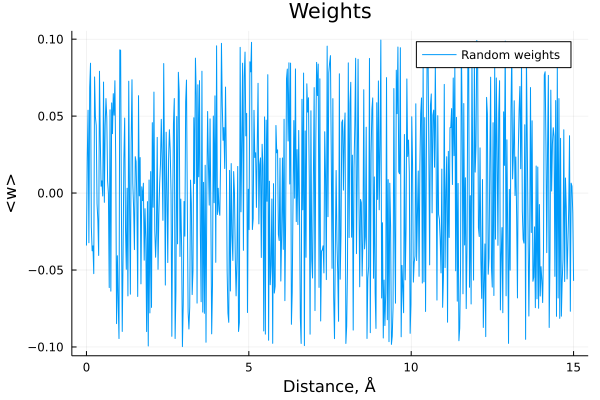

In [368]:
plot(bins, modelGD.weight', title="Weights", label="Random weights")
xlabel!("Distance, Å")
ylabel!("<w>")

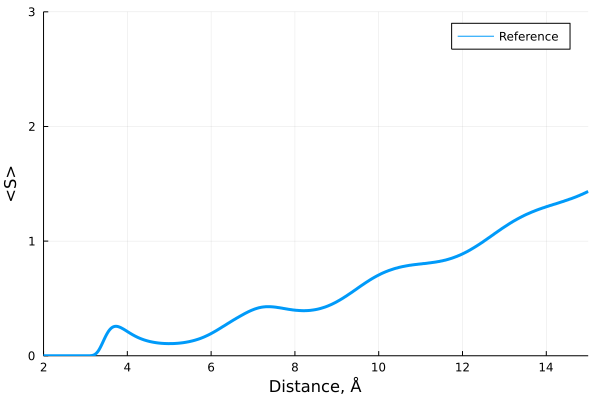

In [335]:
plot(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("<S>")

I will reinitialize the model so that the energy is high for short distances and close to zero for large distances.

Nullify the weigths:

In [5]:
Flux.Optimise.update!(modelGD.weight, modelGD.weight)

1×600 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [370]:
Flux.Optimise.update!(modelMGD.weight, modelMGD.weight)

1×600 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [6]:
"""
function mindistance(hist, parameters)

Returns the minimal occuring distance in the histogram
"""
function mindistance(hist, parameters)
    for i in 1:parameters.Nbins
        if hist[i] != 0
            return((i - 1) * parameters.binWidth)
        end
    end
end;

In [7]:
"""
function repulsion(hist, parameters, shift=0.01, stiffness=500)

Returns repulsion weights for the neural network
"""
function repulsion(hist, parameters, shift=0.01, stiffness=500)
    bins = [bin*parameters.binWidth for bin in 1:parameters.Nbins]
    minDistance = mindistance(histref, parameters)
    α = -log(shift)/minDistance
    potential = zeros(Float32, parameters.Nbins)
    for i in 1:parameters.Nbins
        if bins[i] < minDistance
            potential[i] = stiffness*(exp(-α*bins[i])-shift)
        end
    end
    return(potential)
end;

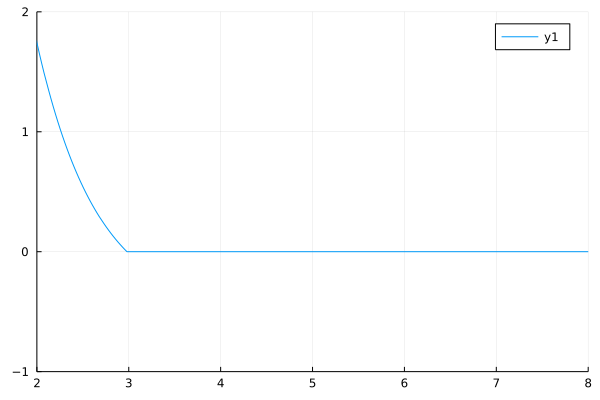

In [25]:
plot(bins, repulsion(histref, parameters, 0.01, 50), xlim=(2, 8), ylim=(-1, 2))

Add repulsion to the initial model (with minus sign to get positive values):

In [371]:
Flux.Optimise.update!(modelGD.weight, -repulsion(histref, parameters, 0.01, 500)')

1×600 Matrix{Float32}:
 476.175  458.059  440.625  423.848  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [372]:
Flux.Optimise.update!(modelMGD.weight, -repulsion(histref, parameters, 0.01, 500)')

1×600 Matrix{Float32}:
 476.175  458.059  440.625  423.848  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

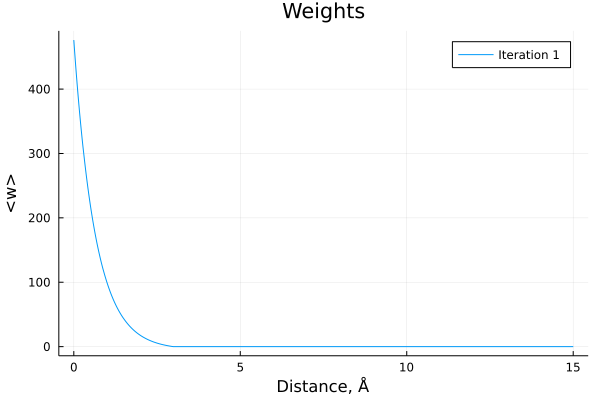

In [373]:
plot(bins, modelGD.weight', title="Weights", label="Iteration 1")
xlabel!("Distance, Å")
ylabel!("<w>")

## 1.3. Running the simulation

In [225]:
function main(conf, parameters, model)    
    # Start the timer
    startTime = Dates.now()
    println("Running MC simulation on $(nworkers()) rank(s)...\n")
    println("Total number of steps: $(parameters.steps * nworkers() / 1E6)M")
    println("Starting at: ", startTime)
    
    # Prepare inputs
    input = conf, parameters, model
    inputs = [input for worker in workers()]
    
    # Run the simulation in parallel
    outputs = pmap(mcrun!, inputs)
    
    # Stop the timer
    stopTime = Dates.now()
    wallTime = Dates.canonicalize(stopTime - startTime)
    println("Stopping at: ", stopTime, "\n")
    println("Walltime: ", wallTime)
    
    return(outputs)
end;

In [226]:
outputs = main(conf, parameters, modelGD);

Running MC simulation on 4 rank(s)...

Total number of steps: 8.0M
Starting at: 2022-03-30T17:07:32.157
      From worker 5:	Acceptance ratio = 0.670256
      From worker 3:	Acceptance ratio = 0.6710045
      From worker 4:	Acceptance ratio = 0.670484
      From worker 2:	Acceptance ratio = 0.6706175
Stopping at: 2022-03-30T17:08:43.878

Walltime: 1 minute, 11 seconds, 721 milliseconds


Saving the model in bson file (can load only under the same name):

In [374]:
@save "modelGD-iter-01.bson" modelGD

In [375]:
@load "modelGD-iter-01.bson" modelGD

In [376]:
histNN = mean([output[1] for output in outputs]);

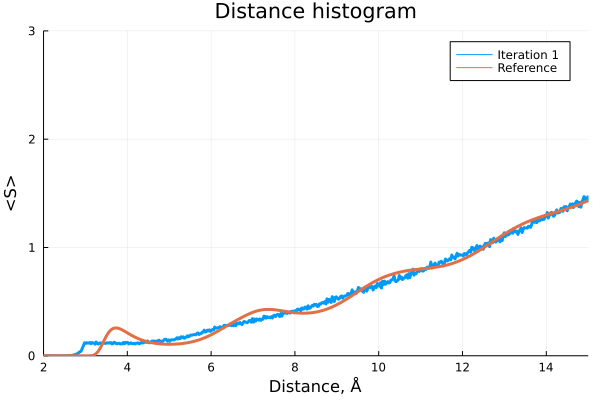

In [377]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Iteration 1", title="Distance histogram")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("<S>")

In [378]:
writehist("histNN-iter-01.dat", histNN, bins)

In [379]:
loss(histNN, histref);

Loss = 1.39951248


In [380]:
energies = mean([output[2] for output in outputs]);

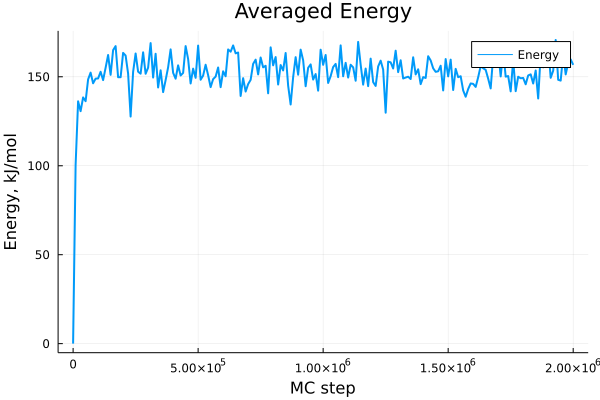

In [381]:
slicing = Int(1E1)
steps = 0:parameters.outfreq:parameters.steps
plot(steps[1:slicing:end], energies[1:slicing:end], lw=2, labels="Energy", title="Averaged Energy")
xlabel!("MC step")
ylabel!("Energy, kJ/mol")

In [383]:
crossWeights = mean([output[3] for output in outputs])
crossBiases = mean([output[4] for output in outputs]);

In [384]:
dLdw, dLdb = computeDerivatives(crossWeights, crossBiases, histNN, histref, modelGD, parameters);

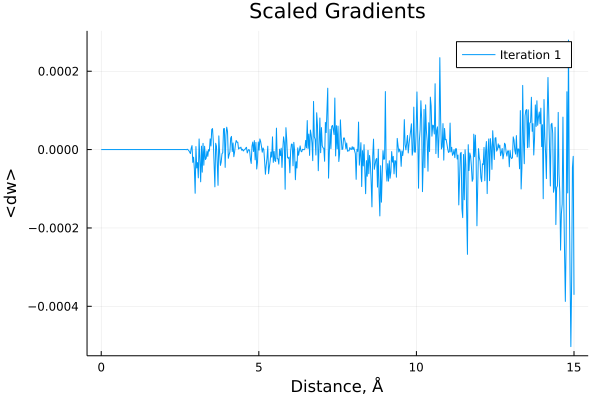

In [396]:
plot(bins, dLdw*parameters.η, label="Iteration 1", title="Scaled Gradients")
xlabel!("Distance, Å")
ylabel!("<dw>")

I have the gradients now. It's time to generate two different models, one with gradient descent and another one with momentum-based GD.

## Gradient descent (GD)

In [386]:
optGD = Descent(parameters.η);

In [388]:
Flux.Optimise.update!(optGD, modelGD.weight, dLdw)

1×600 Matrix{Float32}:
 476.175  458.059  440.625  423.848  …  0.000919974  0.00034297  0.00741207

In [389]:
Flux.Optimise.update!(optGD, modelGD.bias, [dLdb])

1-element Vector{Float32}:
 1.7193537f-10

## Momentum gradient descent (MGD)

In [399]:
ρ = 0.9 # Momentum coefficient

0.9

In [400]:
optMGD = Momentum(parameters.η, ρ);

In [401]:
Flux.Optimise.update!(optMGD, modelMGD.weight, dLdw)

1×600 Matrix{Float32}:
 476.175  458.059  440.625  423.848  …  4.59987f-5  1.71485f-5  0.000370604

In [402]:
Flux.Optimise.update!(optMGD, modelMGD.bias, [dLdb])

1-element Vector{Float32}:
 1.7193537f-10

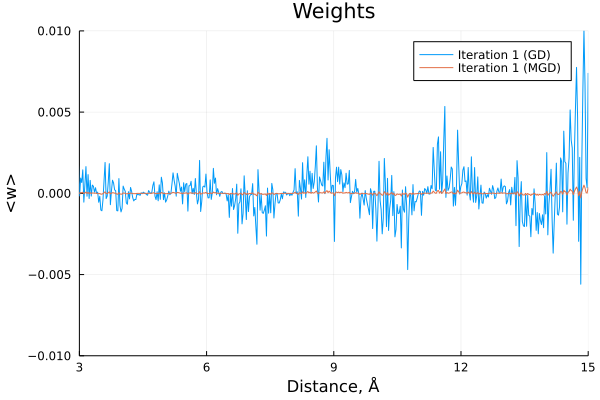

In [409]:
plot(bins, modelGD.weight', title="Weights", label="Iteration 1 (GD)", xlim=(3, 15), ylim=(-0.01, 0.01))
plot!(bins, modelMGD.weight', label="Iteration 1 (MGD)", xlim=(3, 15))
xlabel!("Distance, Å")
ylabel!("<w>")

Momentum needs to gain momentum I suppose... I will try with that first.

In [410]:
@save "modelMGD-iter-02.bson" modelMGD

# 2.1. Second iteration

In [411]:
outputs_02 = main(conf, parameters, modelMGD);

Running MC simulation on 4 rank(s)...

Total number of steps: 8.0M
Starting at: 2022-03-30T17:56:21.820
      From worker 4:	Acceptance ratio = 0.6714485
      From worker 5:	Acceptance ratio = 0.6703745
      From worker 2:	Acceptance ratio = 0.6704695
      From worker 3:	Acceptance ratio = 0.671142
Stopping at: 2022-03-30T17:57:34.321

Walltime: 1 minute, 12 seconds, 501 milliseconds


In [412]:
histNN = mean([output[1] for output in outputs_02]);

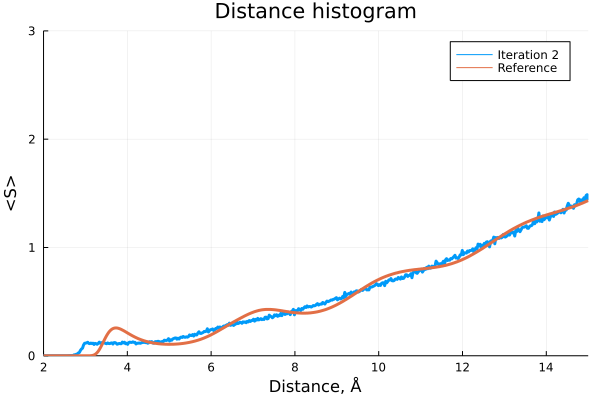

In [413]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Iteration 2", title="Distance histogram")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("<S>")

In [436]:
writehist("histNN-iter-02.dat", histNN, bins)

In [414]:
loss(histNN, histref);

Loss = 1.35822687


In [415]:
crossWeights = mean([output[3] for output in outputs_02])
crossBiases = mean([output[4] for output in outputs_02]);

In [416]:
dLdw, dLdb = computeDerivatives(crossWeights, crossBiases, histNN, histref, modelMGD, parameters);

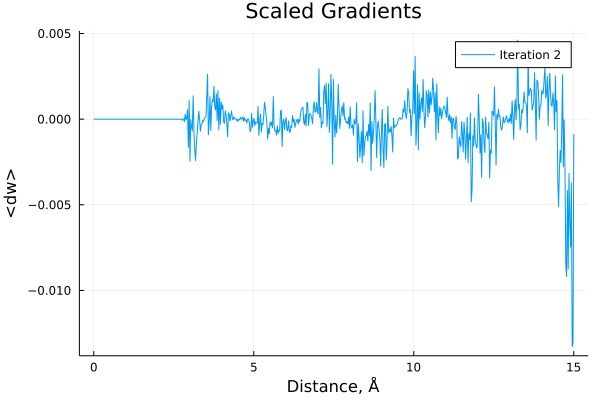

In [418]:
plot(bins, dLdw*parameters.η, label="Iteration 2", title="Scaled Gradients")
xlabel!("Distance, Å")
ylabel!("<dw>")

In [423]:
Flux.Optimise.update!(optMGD, modelMGD.weight, dLdw)

1×600 Matrix{Float32}:
 476.175  458.059  440.625  423.848  …  0.0133681  0.0130611  0.00157275

In [424]:
Flux.Optimise.update!(optMGD, modelMGD.bias, [dLdb])

1-element Vector{Float32}:
 -1.7471184f-9

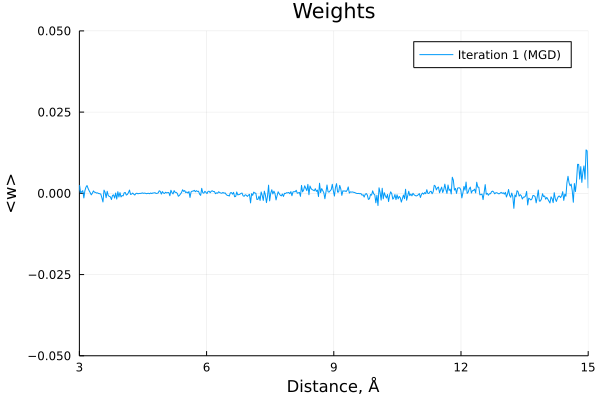

In [434]:
plot(bins, modelMGD.weight', title="Weights", label="Iteration 2 (MGD)", xlim=(3, 15), ylim=(-0.05, 0.05))
xlabel!("Distance, Å")
ylabel!("<w>")

The change in weigths is larger!

In [435]:
@save "modelMGD-iter-03.bson" modelMGD

# 3.1 Third iteration

In [437]:
outputs_03 = main(conf, parameters, modelMGD);

Running MC simulation on 4 rank(s)...

Total number of steps: 8.0M
Starting at: 2022-03-30T18:07:14.400
      From worker 4:	Acceptance ratio = 0.6613265
      From worker 5:	Acceptance ratio = 0.6613735
      From worker 2:	Acceptance ratio = 0.661146
      From worker 3:	Acceptance ratio = 0.6620055
Stopping at: 2022-03-30T18:08:27.699

Walltime: 1 minute, 13 seconds, 299 milliseconds


In [438]:
histNN = mean([output[1] for output in outputs_03]);

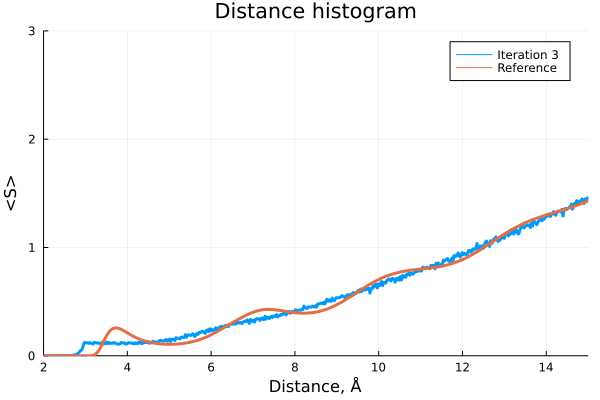

In [439]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Iteration 3", title="Distance histogram")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("<S>")

In [440]:
loss(histNN, histref);

Loss = 1.35115432


In [441]:
crossWeights = mean([output[3] for output in outputs_03])
crossBiases = mean([output[4] for output in outputs_03]);

In [442]:
dLdw, dLdb = computeDerivatives(crossWeights, crossBiases, histNN, histref, modelMGD, parameters);

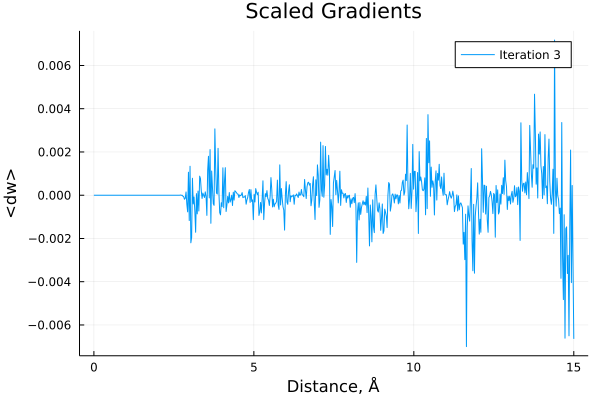

In [443]:
plot(bins, dLdw*parameters.η, label="Iteration 3", title="Scaled Gradients")
xlabel!("Distance, Å")
ylabel!("<dw>")

In [444]:
Flux.Optimise.update!(optMGD, modelMGD.weight, dLdw)

1×600 Matrix{Float32}:
 476.175  458.059  440.625  423.848  …  0.0249086  0.0279908  0.00929877

In [453]:
Flux.Optimise.update!(optMGD, modelMGD.bias, [dLdb])

1-element Vector{Float32}:
 -1.1161564f-8

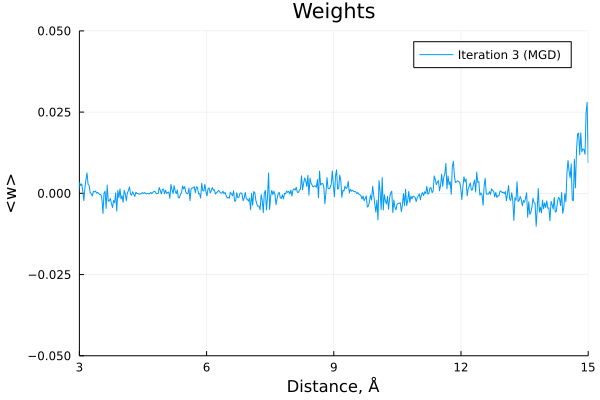

In [446]:
plot(bins, modelMGD.weight', title="Weights", label="Iteration 3 (MGD)", xlim=(3, 15), ylim=(-0.05, 0.05))
xlabel!("Distance, Å")
ylabel!("<w>")

In [447]:
@save "modelMGD-iter-04.bson" modelMGD

# 4.1 Fourth iteration

In [448]:
outputs_04 = main(conf, parameters, modelMGD);

Running MC simulation on 4 rank(s)...

Total number of steps: 8.0M
Starting at: 2022-03-30T18:20:19.202
      From worker 4:	Acceptance ratio = 0.650538
      From worker 5:	Acceptance ratio = 0.6515365
      From worker 2:	Acceptance ratio = 0.651199
      From worker 3:	Acceptance ratio = 0.6511175
Stopping at: 2022-03-30T18:21:33.145

Walltime: 1 minute, 13 seconds, 943 milliseconds


In [449]:
histNN = mean([output[1] for output in outputs_04]);

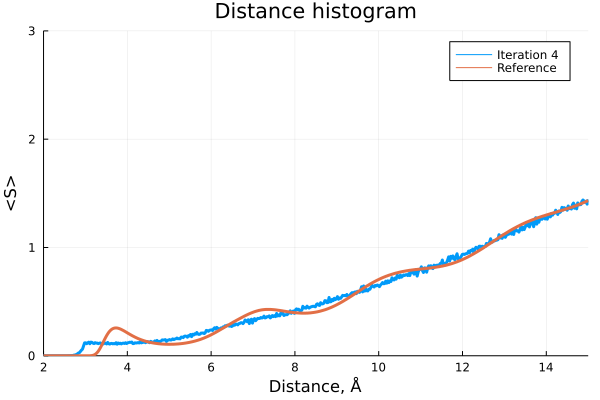

In [450]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Iteration 4", title="Distance histogram")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("<S>")

In [451]:
loss(histNN, histref);

Loss = 1.28880474


I should try this algorithm! I think it's working and sounds promising.